In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from neurosim.models.ssr import StateSpaceRealization as SSR
from neurosim.models.varma import gen_var1_connectivity
from tqdm import tqdm
import pdb
from scipy.stats import ortho_group
from dca.cov_util import calc_pi_from_cross_cov_mats
import itertools

In [3]:
import jax
import jax.numpy as jnp

In [4]:
import sys
sys.path.append('../..')
from utils import calc_loadings
from riccati import riccati_opt, riccati_solve, riccati_

In [37]:
def iterated_PI(ssm, niter=1, return_matrices=True):
    
    P0 = np.zeros(ssm.A.shape)
    Q0 = np.zeros(ssm.A.shape)
    for i in range(niter):
        P = riccati_(P0, ssm.A, ssm.C, ssm.Cbar, ssm.cov)
        P0 = P
        Q = riccati_(Q0, ssm.A.T, ssm.Cbar, ssm.C, ssm.cov)
        Q0 = Q
    if return_matrices:
        return np.trace(P @ Q), P, Q
    else:
        return np.trace(P @ Q)
    #return -0.5 * np.linalg.slogdet(np.eye(P1.shape[0]) - P1 @ Q1)[1]

In [41]:
def full_PI(ssm):
    
    Pminus = riccati_solve(ssm.A, ssm.C, ssm.Cbar, ssm.cov, max_iter=1000)
    Qminus = riccati_solve(ssm.A.T, ssm.Cbar, ssm.C, ssm.cov, max_iter=1000)
#     # Try scipy built-in solver
#     if err2 > 1e-6:
#         Qminus_ = scipy.linalg.solve_discrete_are(ssm.A, ssm.Cbar.T, 
#                                                  np.zeros(ssm.A.shape), -1*ssm.cov, s=-1*ssm.C.T)
#         pdb.set_trace()
    
    pi = -0.5 * np.linalg.slogdet(np.eye(Pminus.shape[0]) - Pminus @ Qminus)[1]
    if pi < 0:
        pdb.set_trace()
    
    return pi

In [5]:
# Does solving the dual riccati equations for a single unit readout yield the right univariate PI?

In [8]:
ssdim = 10
B = np.eye(10)
A = 1/5 * np.random.normal(size=(ssdim, ssdim))

if max(np.abs(np.linalg.eigvals(A))) >= 1:
    while max(np.abs(np.linalg.eigvals(A))) >= 1:
        A = 1/5 * np.random.normal(size=(ssdim, ssdim)) 

# Ambient state covariance
P = scipy.linalg.solve_discrete_lyapunov(A, B @ B.T)
        
# Load onto a random unit
C = np.zeros((1, 10))
C[:, np.random.choice(np.arange(10))] = 1

ssm = SSR(A=A, B=B, C=C)

Pmin = riccati_solve(A, C, ssm.Cbar, ssm.cov, tol=1e-8, Pinit=P)
Qmin = riccati_solve(A.T, ssm.Cbar, C, ssm.cov, tol=1e-8, Pinit=P)

ccm = ssm.autocorrelation(10)
    
# Does the PI coincide?
pi_emp = calc_pi_from_cross_cov_mats(ssm.autocorrelation(50))
pi_cc = -1/2 * np.linalg.slogdet(np.eye(P.shape[0]) - Pmin @ Qmin)[1]
print(pi_emp)
print(pi_cc)

0.04160517760472615
0.04160517779668444


### Convergence of Riccati equation as a function of the projection dimension

In [154]:
# Converge of Riccati equation as a function of the projection dimension

In [132]:
ssdim = 50

In [133]:
A = 1/(2 * np.sqrt(ssdim)) * np.random.normal(size=(ssdim, ssdim))
while np.max(np.abs(np.linalg.eigvals(A))) > 1:
    A = 1/(2 * np.sqrt(ssdim)) * np.random.normal(size=(ssdim, ssdim))
B = np.eye(ssdim)

In [16]:
dims = np.arange(1, ssdim)
reps = 50
norm_traces = np.zeros((dims.size, reps, 21))

for i, dim in enumerate(dims):
    for j in range(reps):
        C = scipy.stats.ortho_group.rvs(ssdim)[:, 0:dim].T
        ssm = SSR(A=A, B=B, C=C)
        P0 = np.zeros(A.shape)
        P = [P0]
        for k in range(20):
            p_ = riccati_(P0, A, C, ssm.Cbar, ssm.cov)
            P.append(p_)
            P0 = p_        
        
        norm_trace_ = np.array([np.linalg.norm(p_) for p_ in P])
        norm_traces[i, j, :] = norm_trace_

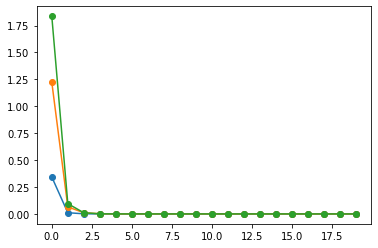

In [17]:
plt.plot(np.mean(np.diff(norm_traces[0, ...]), axis=0), '-o')
plt.plot(np.mean(np.diff(norm_traces[10, ...]), axis=0), '-o')
plt.plot(np.mean(np.diff(norm_traces[20, ...]), axis=0), '-o')

In [ ]:
# Projections onto single units

In [137]:
dims = np.arange(1, ssdim)
reps = 50
norm_traces = np.zeros((dims.size, reps, 21))

for i, dim in tqdm(enumerate(dims)):
    for j in range(reps):
        C = np.zeros((dim, ssdim))
        for d_ in range(dim):
            C[d_, np.random.choice(np.arange(ssdim))] = 1
        ssm = SSR(A=A, B=B, C=C)
        P0 = np.zeros(A.shape)
        P = [P0]
        for k in range(20):
            p_ = riccati_(P0, A, C, ssm.Cbar, ssm.cov)
            P.append(p_)
            P0 = p_        
        
        norm_trace_ = np.array([np.linalg.norm(p_) for p_ in P])
        norm_traces[i, j, :] = norm_trace_

49it [02:13,  2.72s/it]


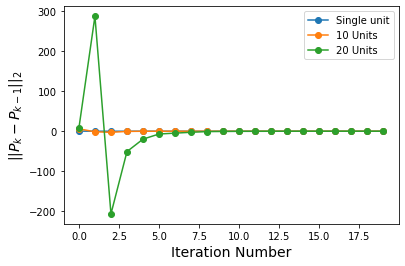

In [138]:
plt.plot(np.mean(np.diff(norm_traces[0, ...]), axis=0), '-o')
plt.plot(np.mean(np.diff(norm_traces[10, ...]), axis=0), '-o')
plt.plot(np.mean(np.diff(norm_traces[20, ...]), axis=0), '-o')
plt.legend(['Single unit', '10 Units', '20 Units'])
plt.xlabel('Iteration Number', fontsize=14)
plt.ylabel(r'$||P_k - P_{k - 1}||_2$', fontsize=14)
plt.savefig('iterate_convergence.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Wtf is going on here?

### Single riccati iteration, single node

In [27]:
C = np.zeros((1, ssdim))
C[:, np.random.choice(np.arange(ssdim))] = 1
ssm = SSR(A=A, B=B, C=C)

In [38]:
np.count_nonzero(C @ ssm.P @ C.T)

1

In [39]:
# Verify formula for the trace after a single iteration

In [40]:
P1 = riccati_(np.zeros(A.shape), A, C, ssm.Cbar, ssm.cov)
Q1 = riccati_(np.zeros(A.shape), A, ssm.Cbar, C, ssm.cov)

In [41]:
np.trace(P1 @ Q1)

0.00020875215085458258

In [44]:
ssm.P[12, 12]**-2 * (A[12, :] @ ssm.P[:, 12]) * (ssm.P[12, :] @ A.T[:, 12])

0.00020875215085458307

### Correlate single iteration maximizing nodes with true PI maximizing nodes

In [51]:
# Random networks

In [50]:
# Configuration model

In [48]:
# Configuration model + clustering

### Submodularity/Supermodularity Property of PI

In [45]:
# Is PI submodular/supermodular?
# Does this property hold monotonically for all order iterations?

In [ ]:
# Choose ssdim = 10
# For S, S' = S + 1, choose all |S| subsets and add all possible nodes, and measure the difference in PI gain
# Do this across several different matrix models

In [ ]:
# First verify submodularity for known quantities (e.g. controllability Gramian quantities)

In [96]:
ssdim = 10
reps = 10

n_subset_combos = int(1e3)

diff = np.zeros((reps, ssdim - 2), dtype=np.object)

for i in tqdm(range(reps)):
    A = 1/5 * np.random.normal(size=(ssdim, ssdim))

    if max(np.abs(np.linalg.eigvals(A))) >= 1:
        while max(np.abs(np.linalg.eigvals(A))) >= 1:
            A = 1/5 * np.random.normal(size=(ssdim, ssdim)) 
    
    S = np.arange(1, ssdim - 1)
    
    for j in tqdm(range(S.size)):
        
        # Iterate over all size |S(j)| and |S(j)| + 1 sets of neurons 
        subsets1 = itertools.combinations(np.arange(ssdim), S[j])
        subsets2 = itertools.combinations(np.arange(ssdim), S[j] + 1)
        
        # Need to take a random selection of the subsets
        possible_subset_combos = list(itertools.product(subsets1, subsets2))
        combos = list(np.random.choice(len(possible_subset_combos),
                                       min(len(possible_subset_combos),
                                           n_subset_combos)))
        
        subset_combos = np.array(possible_subset_combos)[combos]
        diff[i, j] = []
        for subset1, subset2 in subset_combos:
            
            # Use characterization in terms of union/intersection            
            
            B1 = np.zeros((S[j], ssdim))
            for d_ in range(len(subset1)):
                B1[d_, subset1[d_]] = 1
                
            ssm1 = SSR(A=A, B=B1.T, C=np.eye(A.shape[0]))

            B2 = np.zeros((S[j] + 1, ssdim))
            for d_ in range(len(subset2)):
                B2[d_, subset2[d_]] = 1
            ssm2 = SSR(A=A, B=B2.T, C=np.eye(A.shape[0]))

            fA = np.linalg.slogdet(ssm1.P)[1]
            fB = np.linalg.slogdet(ssm2.P)[1]
            
            # Union
            subset_union = list(set(subset1).union(set(subset2)))
            Bunion = np.zeros((len(subset_union), ssdim))
            for d_ in range(len(subset_union)):
                Bunion[d_, subset_union[d_]] = 1
            ssm_union = SSR(A=A, B=Bunion.T, C=np.eye(A.shape[0]))
            
            fAuB = np.linalg.slogdet(ssm_union.P)[1]
            
            # Intersection
            subset_int = list(set(subset1).intersection(set(subset2)))
            Bint = np.zeros((len(subset_int), ssdim))
            for d_ in range(len(subset_int)):
                Bint[d_, subset_int[d_]] = 1
            ssm_int = SSR(A=A, B=Bint.T, C=np.eye(A.shape[0]))
            
            fAiB = np.linalg.slogdet(ssm_int.P)[1]
            
            # This quantity should be positive
            diff[i, j].append(fA + fB - fAuB - fAiB)

100%|██████████| 10/10 [01:23<00:00,  8.40s/it]


In [99]:
min_ = 0
for i in range(diff.shape[0]):
    for j in range(diff.shape[1]):
        if min(diff[i, j]) < min_:
            min_ = min(diff[i, j])

In [90]:
# Verify submodularity of log det of the Kalman MMSE
ssdim = 10
reps = 10

n_subset_combos = int(1e3)

diff = np.zeros((reps, ssdim - 2), dtype=np.object)

for i in tqdm(range(reps)):
    A = 1/5 * np.random.normal(size=(ssdim, ssdim))

    if max(np.abs(np.linalg.eigvals(A))) >= 1:
        while max(np.abs(np.linalg.eigvals(A))) >= 1:
            A = 1/5 * np.random.normal(size=(ssdim, ssdim)) 
    
    S = np.arange(1, ssdim - 1)
    
    for j in tqdm(range(S.size)):
        
        # Iterate over all size |S(j)| and |S(j)| + 1 sets of neurons 
        subsets1 = itertools.combinations(np.arange(ssdim), S[j])
        subsets2 = itertools.combinations(np.arange(ssdim), S[j] + 1)
        
        # Need to take a random selection of the subsets
        possible_subset_combos = list(itertools.product(subsets1, subsets2))
        combos = list(np.random.choice(len(possible_subset_combos),
                                       min(len(possible_subset_combos),
                                           n_subset_combos)))
        
        subset_combos = np.array(possible_subset_combos)[combos]
        diff[i, j] = []
        for subset1, subset2 in subset_combos:
            
            # Use characterization in terms of union/intersection            

            C1 = np.zeros((S[j], ssdim))
            for d_ in range(len(subset1)):
                C1[d_, subset1[d_]] = 1
                
            ssm1 = SSR(A=A, B=np.eye(A.shape[0]), C=C1)
            P = scipy.linalg.solve_discrete_are(A, C1.T, np.eye(A.shape[0]), ssm1.cov)
            fA = np.linalg.slogdet(P)[1]
            
            
            C2 = np.zeros((S[j] + 1, ssdim))
            for d_ in range(len(subset2)):
                C2[d_, subset2[d_]] = 1
            ssm2 = SSR(A=A, B=np.eye(A.shape[0]), C=C2)

            P = scipy.linalg.solve_discrete_are(A, C2.T, np.eye(A.shape[0]), ssm2.cov)
            fB = np.linalg.slogdet(P)[1]
            
            # Union
            subset_union = list(set(subset1).union(set(subset2)))
            Cunion = np.zeros((len(subset_union), ssdim))
            for d_ in range(len(subset_union)):
                Cunion[d_, subset_union[d_]] = 1
            ssm_union = SSR(A=A, B=np.eye(A.shape[0]), C=Cunion)
            P = scipy.linalg.solve_discrete_are(A, Cunion.T, np.eye(A.shape[0]), ssm_union.cov)
            fAuB = np.linalg.slogdet(P)[1]
            
            # Intersection
            subset_int = list(set(subset1).intersection(set(subset2)))
            
            if len(subset_int) > 0:
                Cint = np.zeros((len(subset_int), ssdim))
                for d_ in range(len(subset_int)):
                    Cint[d_, subset_int[d_]] = 1
                ssm_int = SSR(A=A, B=np.eye(A.shape[0]), C=Cint)

                P = scipy.linalg.solve_discrete_are(A, Cint.T, np.eye(A.shape[0]), ssm_int.cov)
                fAiB = np.linalg.slogdet(P)[1]
            else:
                # Effectively, no sensors were placed here. Let the error variance equal the state variance
                fAiB = np.linalg.slogdet(scipy.linalg.solve_discrete_lyapunov(A, np.eye(A.shape[0])))[1]
            # This quantity should be positive
            diff[i, j].append(fA + fB - fAuB - fAiB)

  0%|          | 0/8 [00:00<?, ?it/s]/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

100%|██████████| 10/10 [04:15<00:00, 25.57s/it]


In [ ]:
# Maybe do a box and whisker plot

In [94]:
len(diff[0, 0])

450

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


{'whiskers': [<matplotlib.lines.Line2D at 0x7f53805c8550>,
 'caps': [<matplotlib.lines.Line2D at 0x7f53805c8fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f53805cef50>,
 'medians': [<matplotlib.lines.Line2D at 0x7f53805ecad0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f53805eb050>,
 'means': []}

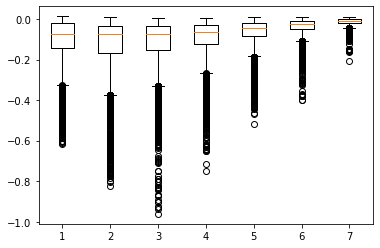

In [99]:
X = []
for i in range(1, diff.shape[1]):
    X.append([])
    for j in range(diff.shape[0]):
        X[i - 1].extend(diff[j, i])
plt.boxplot(X)

In [ ]:
# What about PI?

In [100]:
ssdim = 10
reps = 10

n_subset_combos = int(1e3)

diff_pi = np.zeros((reps, ssdim - 2), dtype=np.object)

for i in tqdm(range(reps)):
    A = 1/5 * np.random.normal(size=(ssdim, ssdim))

    if max(np.abs(np.linalg.eigvals(A))) >= 1:
        while max(np.abs(np.linalg.eigvals(A))) >= 1:
            A = 1/5 * np.random.normal(size=(ssdim, ssdim)) 
    
    S = np.arange(1, ssdim - 1)
    
    for j in tqdm(range(S.size)):
        
        # Iterate over all size |S(j)| and |S(j)| + 1 sets of neurons 
        subsets1 = itertools.combinations(np.arange(ssdim), S[j])
        subsets2 = itertools.combinations(np.arange(ssdim), S[j] + 1)
        
        # Need to take a random selection of the subsets
        possible_subset_combos = list(itertools.product(subsets1, subsets2))
        combos = list(np.random.choice(len(possible_subset_combos),
                                       min(len(possible_subset_combos),
                                           n_subset_combos)))
        
        subset_combos = np.array(possible_subset_combos)[combos]
        diff_pi[i, j] = []
        for subset1, subset2 in subset_combos:
            
            # Use characterization in terms of union/intersection            

            C1 = np.zeros((S[j], ssdim))
            for d_ in range(len(subset1)):
                C1[d_, subset1[d_]] = 1
                
            ssm1 = SSR(A=A, B=np.eye(A.shape[0]), C=C1)
            fA = full_PI(ssm1)
            
            
            C2 = np.zeros((S[j] + 1, ssdim))
            for d_ in range(len(subset2)):
                C2[d_, subset2[d_]] = 1
            ssm2 = SSR(A=A, B=np.eye(A.shape[0]), C=C2)

            fB = full_PI(ssm2)
            
            # Union
            subset_union = list(set(subset1).union(set(subset2)))
            Cunion = np.zeros((len(subset_union), ssdim))
            for d_ in range(len(subset_union)):
                Cunion[d_, subset_union[d_]] = 1
            ssm_union = SSR(A=A, B=np.eye(A.shape[0]), C=Cunion)
            fAuB = full_PI(ssm_union)
            
            # Intersection
            subset_int = list(set(subset1).intersection(set(subset2)))
            
            if len(subset_int) > 0:
                Cint = np.zeros((len(subset_int), ssdim))
                for d_ in range(len(subset_int)):
                    Cint[d_, subset_int[d_]] = 1
                ssm_int = SSR(A=A, B=np.eye(A.shape[0]), C=Cint)
                fAiB = full_PI(ssm_int)
            else:
                # Effectively, no sensors were placed here. 0 PI
                fAiB = 0
            # This quantity should be positive
            diff_pi[i, j].append(fA + fB - fAuB - fAiB)

  0%|          | 0/8 [00:00<?, ?it/s]/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

100%|██████████| 10/10 [1:52:11<00:00, 673.18s/it]


In [102]:
import pickle
with open('pi_submod_test.dat', 'wb') as f:
    f.write(pickle.dumps(diff_pi))

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


{'whiskers': [<matplotlib.lines.Line2D at 0x7f536863b310>,
 'caps': [<matplotlib.lines.Line2D at 0x7f536863bd90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5368660d10>,
 'medians': [<matplotlib.lines.Line2D at 0x7f536864e890>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f536864edd0>,
 'means': []}

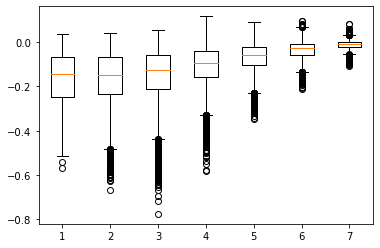

In [101]:
fig, ax = plt.subplots()

X = []
for i in range(1, diff_pi.shape[1]):
    X.append([])
    for j in range(diff_pi.shape[0]):
        X[i - 1].extend(diff_pi[j, i])
plt.boxplot(X)

In [120]:
# Is not submodular

In [ ]:
# Is this a property of non-normality of A?

In [103]:
ssdim = 10
reps = 10

n_subset_combos = int(1e3)

diff_pi2 = np.zeros((reps, ssdim - 2), dtype=np.object)

for i in tqdm(range(reps)):
#     A = 1/5 * np.random.normal(size=(ssdim, ssdim))

#     if max(np.abs(np.linalg.eigvals(A))) >= 1:
#         while max(np.abs(np.linalg.eigvals(A))) >= 1:
#             A = 1/5 * np.random.normal(size=(ssdim, ssdim)) 
    A = np.diag(np.random.uniform(-0.5, 0.5, size=(ssdim,)))
    S = np.arange(1, ssdim - 1)
    
    for j in tqdm(range(S.size)):
        
        # Iterate over all size |S(j)| and |S(j)| + 1 sets of neurons 
        subsets1 = itertools.combinations(np.arange(ssdim), S[j])
        subsets2 = itertools.combinations(np.arange(ssdim), S[j] + 1)
        
        # Need to take a random selection of the subsets
        possible_subset_combos = list(itertools.product(subsets1, subsets2))
        combos = list(np.random.choice(len(possible_subset_combos),
                                       min(len(possible_subset_combos),
                                           n_subset_combos)))
        
        subset_combos = np.array(possible_subset_combos)[combos]
        diff_pi2[i, j] = []
        for subset1, subset2 in subset_combos:
            
            # Use characterization in terms of union/intersection            

            C1 = np.zeros((S[j], ssdim))
            for d_ in range(len(subset1)):
                C1[d_, subset1[d_]] = 1
                
            ssm1 = SSR(A=A, B=np.eye(A.shape[0]), C=C1)
            fA = full_PI(ssm1)
            
            
            C2 = np.zeros((S[j] + 1, ssdim))
            for d_ in range(len(subset2)):
                C2[d_, subset2[d_]] = 1
            ssm2 = SSR(A=A, B=np.eye(A.shape[0]), C=C2)

            fB = full_PI(ssm2)
            
            # Union
            subset_union = list(set(subset1).union(set(subset2)))
            Cunion = np.zeros((len(subset_union), ssdim))
            for d_ in range(len(subset_union)):
                Cunion[d_, subset_union[d_]] = 1
            ssm_union = SSR(A=A, B=np.eye(A.shape[0]), C=Cunion)
            fAuB = full_PI(ssm_union)
            
            # Intersection
            subset_int = list(set(subset1).intersection(set(subset2)))
            
            if len(subset_int) > 0:
                Cint = np.zeros((len(subset_int), ssdim))
                for d_ in range(len(subset_int)):
                    Cint[d_, subset_int[d_]] = 1
                ssm_int = SSR(A=A, B=np.eye(A.shape[0]), C=Cint)
                fAiB = full_PI(ssm_int)
            else:
                # Effectively, no sensors were placed here. 0 PI
                fAiB = 0
            # This quantity should be positive
            diff_pi2[i, j].append(fA + fB - fAuB - fAiB)

  0%|          | 0/8 [00:00<?, ?it/s]/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

100%|██████████| 10/10 [38:25<00:00, 230.56s/it]


In [122]:
diff

array([[list([5.551115123125783e-17, 0.0, -5.551115123125783e-17, 5.551115123125783e-17, -5.551115123125783e-17, 0.0, -5.551115123125783e-17, 3.885780586188048e-16, 5.551115123125783e-17, 1.1102230246251565e-16, 2.7755575615628914e-16, -2.220446049250313e-16, 6.938893903907228e-17, 5.551115123125783e-17, -8.326672684688674e-17, -6.938893903907228e-17, 6.071532165918825e-18, 1.3877787807814457e-16, -1.3877787807814457e-16, 1.1102230246251565e-16, 2.7755575615628914e-17, -1.1102230246251565e-16, -2.220446049250313e-16, 1.8041124150158794e-16, -5.551115123125783e-17, 5.551115123125783e-17, 0.0, 1.3877787807814457e-16, -1.1102230246251565e-16, 8.326672684688674e-17, -1.6653345369377348e-16, -5.551115123125783e-17, -2.7755575615628914e-16, -2.220446049250313e-16, -5.551115123125783e-17, -1.1449174941446927e-16, 1.1102230246251565e-16, 5.551115123125783e-17, -1.1102230246251565e-16, 0.0, 5.551115123125783e-17, 1.6653345369377348e-16, 1.249000902703301e-16, 5.551115123125783e-17, 0.0, 0.0, -2

In [124]:
# Wow! Exactly modular in the normal case

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of list

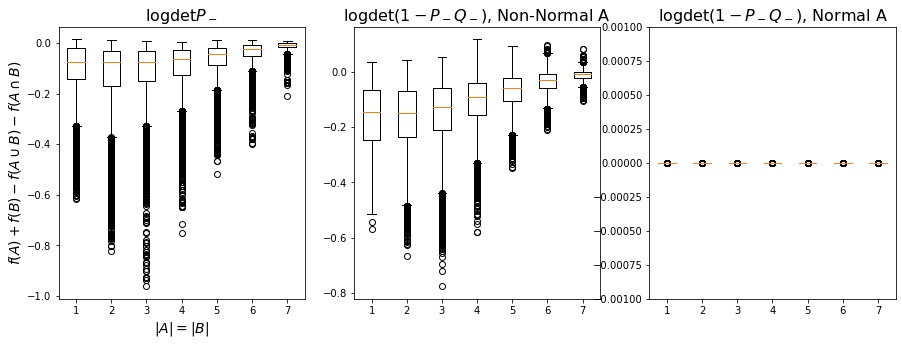

In [116]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

X = []
for i in range(1, diff.shape[1]):
    X.append([])
    for j in range(diff.shape[0]):
        X[i - 1].extend(diff[j, i])
ax[0].boxplot(X)
ax[0].set_title(r'$\log\det P_-$', fontsize=16)
ax[0].set_ylabel(r'$f(A) + f(B) - f(A \cup B) - f(A \cap B)$', fontsize=14)
ax[0].set_xlabel(r'$|A| = |B|$', fontsize=14)
ax[0].set_xticklabels(S)

X = []
for i in range(1, diff_pi.shape[1]):
    X.append([])
    for j in range(diff_pi.shape[0]):
        X[i - 1].extend(diff_pi[j, i])
ax[1].boxplot(X)
ax[1].set_title(r'$\log\det(1 - P_- Q_-)$, Non-Normal A', fontsize=16)


X = []
for i in range(1, diff_pi2.shape[1]):
    X.append([])
    for j in range(diff_pi2.shape[0]):
        X[i - 1].extend(diff_pi2[j, i])
ax[2].boxplot(X)
ax[2].set_title(r'$\log\det(1 - P_- Q_-)$, Normal A', fontsize=16)
ax[2].set_ylim([-1e-3, 1e-3])

fig.savefig('submodularity_comparison.pdf', bbox_inches='tight', pad_inches=0)

In [91]:
# Demonstrate that the violation of submodularity increases with increased matrix non-normality (?)

### Low order riccati iterates

In [130]:
# Next experiments: How correlated are the single iterate nodes with the high PI nodes? What about
# local "microcircuits"

# Does the suboptimality of greedy selection strategies scale with the matrix non-normality?

In [34]:
np.linalg.pinv([[0]])

array([[0.]])

In [126]:
reps = 100
niters = 3
ssdim = 50

sparsity = np.linspace(0, 0.8, 10)

B = np.eye(ssdim)

singlePI = np.zeros((reps, ssdim, sparsity.size, niters))
fullPI = np.zeros((reps, ssdim, sparsity.size))

for i in tqdm(range(reps)):
    for ii, sparsity_ in enumerate(sparsity):
        A = 1/(2 * np.sqrt(ssdim * (1 - sparsity_))) * np.random.normal(size=(ssdim, ssdim)) 
        zeros = np.random.choice(A.size, int(sparsity_ * A.size))
        for zero in zeros:
            A[np.unravel_index(zero, A.shape)] = 0        
        if max(np.abs(np.linalg.eigvals(A))) >= 1:
            while max(np.abs(np.linalg.eigvals(A))) >= 1:
                A = 1/(2 * np.sqrt(ssdim * (1 - sparsity_))) * np.random.normal(size=(ssdim, ssdim)) 
                zeros = np.random.choice(A.size, int(sparsity_ * A.size))
                for zero in zeros:
                    A[np.unravel_index(zero, A.shape)] = 0        

        # Iterate over the nodes and calculate the single iterate PI
        for j in tqdm(range(ssdim)):
            C = np.zeros((1, ssdim))
            C[:, j] = 1
            ssm = SSR(A=A, B=B, C=C) 

            for k in range(niters): 
                singlePI[i, j, ii, k] = iterated_PI(ssm, k + 1, return_matrices=False)
            
            fullPI_ = full_PI(ssm)
            fullPI[i, j, ii] = full_PI(ssm)

  0%|          | 0/100 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [127]:
# Load from precalculated
import pickle
with open('single_unit_iterate_comparison.dat', 'rb') as f:
    singlePI = pickle.load(f)
    fullPI = pickle.load(f)

In [47]:
singlePI.shape

(100, 50, 10, 3)

In [60]:
fullPI[0, 7, :]

array([0.00174806, 0.01124624, 0.00065967, 0.00113918, 0.00029052,
       0.03945216, 0.00514208, 0.00413915, 0.0347901 , 0.05270408])

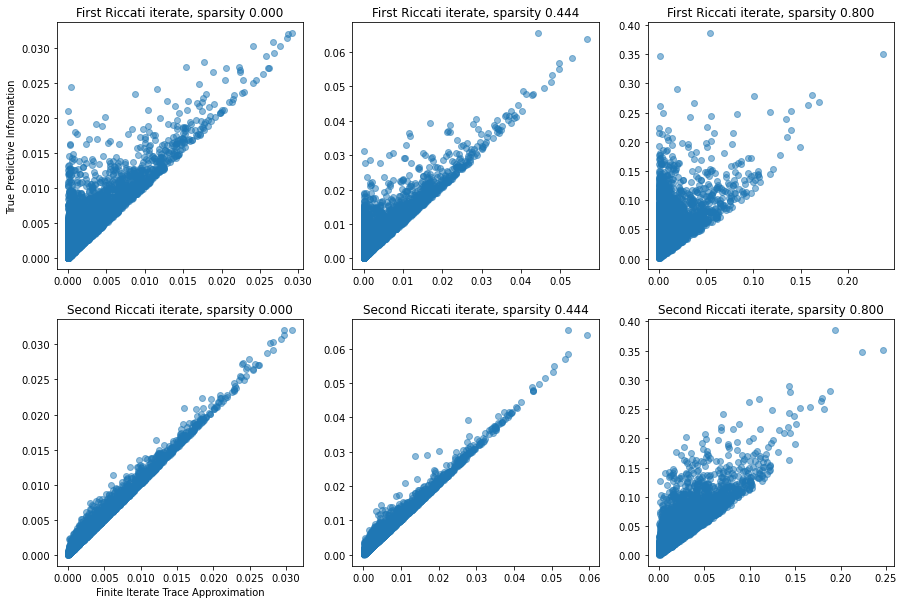

In [76]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for i, sidx in enumerate([0, 5, 9]):
    ax[0, i].scatter(singlePI[..., sidx, 0].ravel()/2, fullPI[..., sidx].ravel(), alpha=0.5)
    ax[1, i].scatter(singlePI[..., sidx, 1].ravel()/2, fullPI[..., sidx].ravel(), alpha=0.5)
    ax[0, i].set_title('First Riccati iterate, sparsity %.3f' % sparsity[sidx])
    ax[1, i].set_title('Second Riccati iterate, sparsity %.3f' % sparsity[sidx])
ax[0, 0].set_ylabel('True Predictive Information')
ax[1, 0].set_xlabel('Finite Iterate Trace Approximation')
plt.savefig('SU_Riccati_iterates.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Inspect 2 observations 
# (1) Why is the trace consistently larger than the log det?
# (2) Does PI really go up upon sparsifying the matrix? Is this just a consequence of larger eigenvalues?

In [65]:
U = scipy.stats.ortho_group.rvs(50)
A = U @ np.diag(np.random.uniform(0, 1, size=(50,))) @ U.T

In [70]:
-1 * np.linalg.slogdet(np.eye(A.shape[0]) - A)[1]

61.36581734092495

In [74]:
np.trace(A) + 0.5 * np.trace(np.linalg.matrix_power(A, 2)) + 1/3 * np.trace(np.linalg.matrix_power(A, 3))

39.876546699652174

In [77]:
# On (1), we just forgot a factor of 1/2

In [80]:
# On (2), we keep track of the eigenvalues
eigvals = np.zeros((reps, sparsity.size, ssdim))
for i in tqdm(range(reps)):
    for ii, sparsity_ in enumerate(sparsity):
        A = 1/(2 * np.sqrt(ssdim * (1 - sparsity_))) * np.random.normal(size=(ssdim, ssdim)) 
        zeros = np.random.choice(A.size, int(sparsity_ * A.size))
        for zero in zeros:
            A[np.unravel_index(zero, A.shape)] = 0        
        if max(np.abs(np.linalg.eigvals(A))) >= 1:
            while max(np.abs(np.linalg.eigvals(A))) >= 1:
                A = 1/(2 * np.sqrt(ssdim * (1 - sparsity_))) * np.random.normal(size=(ssdim, ssdim)) 
                zeros = np.random.choice(A.size, int(sparsity_ * A.size))
                for zero in zeros:
                    A[np.unravel_index(zero, A.shape)] = 0        
        eigvals[i, ii, :] = np.abs(np.linalg.eigvals(A))
        

100%|██████████| 100/100 [00:02<00:00, 43.19it/s]


In [118]:
# Inspect a few different ideas for "1.5" order type approximations
reps = 100
niters = 3
ssdim = 50

sparsity = np.linspace(0, 0.8, 10)
sparsity = np.array([sparsity[0], sparsity[5], sparsity[9]])

B = np.eye(ssdim)

PIapprox_1 = np.zeros((reps, ssdim, sparsity.size))
PIapprox_2 = np.zeros(PIapprox_1.shape)
PIapprox_3 = np.zeros(PIapprox_1.shape)
PIapprox_4 = np.zeros(PIapprox_1.shape)

fullPI = np.zeros((reps, ssdim, sparsity.size))

for i in tqdm(range(reps)):
    for ii, sparsity_ in enumerate(sparsity):
        A = 1/(2 * np.sqrt(ssdim * (1 - sparsity_))) * np.random.normal(size=(ssdim, ssdim)) 
        zeros = np.random.choice(A.size, int(sparsity_ * A.size))
        for zero in zeros:
            A[np.unravel_index(zero, A.shape)] = 0        
        if max(np.abs(np.linalg.eigvals(A))) >= 1:
            while max(np.abs(np.linalg.eigvals(A))) >= 1:
                A = 1/(2 * np.sqrt(ssdim * (1 - sparsity_))) * np.random.normal(size=(ssdim, ssdim)) 
                zeros = np.random.choice(A.size, int(sparsity_ * A.size))
                for zero in zeros:
                    A[np.unravel_index(zero, A.shape)] = 0        

        # Iterate over the nodes and calculate the single iterate PI
        for j in tqdm(range(ssdim)):
            C = np.zeros((1, ssdim))
            C[:, j] = 1
            ssm = SSR(A=A, B=B, C=C) 

            # Approximation 1: Trace(P_1 Q_2)
            _, P1, Q1 = iterated_PI(ssm, 1, return_matrices=True)
            _, P2, Q2 = iterated_PI(ssm, 2, return_matrices=True)
            PIapprox_1[i, j, ii] = 0.5 * np.trace(P1 @ Q2)
            # Approximation 2: Trace(P_2, Q_1)
            PIapprox_2[i, j, ii] = 0.5 * np.trace(P2 @ Q1)
            
            # Approximation 3: Take P1 and Q1 and step them by the dynamics only
            P2_ = A @ P1 @ A.T
            Q2_ = A.T @ Q1 @ A
            PIapprox_3[i, j, ii] = 0.5 * np.trace(P2_ @ Q2_)
            
            # Approximation 4: Step by dynamics for 2 time steps
            P3_ = A @ P2_ @ A.T
            Q3_ = A.T @ Q2_ @ A
            PIapprox_4[i, j, ii] = 0.5 * np.trace(P3_ @ Q3_)
    
            fullPI_ = full_PI(ssm)
            fullPI[i, j, ii] = full_PI(ssm)

100%|██████████| 50/50 [00:03<00:00, 12.77it/s]

100%|██████████| 50/50 [00:04<00:00, 11.96it/s]

100%|██████████| 50/50 [00:03<00:00, 13.56it/s]

100%|██████████| 50/50 [00:03<00:00, 12.98it/s]

  8%|▊         | 4/50 [00:00<00:06,  6.91it/s]


100%|██████████| 50/50 [00:03<00:00, 13.36it/s]

100%|██████████| 50/50 [00:04<00:00, 12.41it/s]

 36%|███▌      | 18/50 [00:01<00:02, 14.40it/s]


100%|██████████| 50/50 [00:03<00:00, 13.94it/s]

100%|██████████| 50/50 [00:03<00:00, 12.83it/s]

100%|██████████| 50/50 [00:03<00:00, 14.10it/s]

100%|██████████| 50/50 [00:04<00:00, 12.42it/s]

 30%|███       | 15/50 [00:02<00:05,  6.97it/s]


100%|██████████| 50/50 [00:03<00:00, 13.46it/s]

100%|██████████| 50/50 [00:03<00:00, 12.76it/s]

 80%|████████  | 40/50 [00:02<00:00, 13.77it/s]


100%|██████████| 50/50 [00:03<00:00, 13.66it/s]

100%|██████████| 50/50 [00:03<00:00, 13.37it/s]

100%|██████████| 50/50 [00:03<00:00, 13.74it/s]

100%|██████████| 50/50 [00:04<00:00, 12.11it/s]

 52%|█████▏    | 26/50 [00:08<00:06,  3.75it/s]


100%|██████████| 50/50 [00:03<00:00, 13.53it/s]

100%|██████████| 50/50 [00:04<00:00, 12.43it/s]

100%|██████████| 50/50 [00:03<00:00, 13.46it/s]

 24%|██▍       | 12/50 [00:00<00:02, 12.99it/s]


100%|██████████| 50/50 [00:04<00:00, 12.43it/s]

100%|██████████| 50/50 [00:03<00:00, 13.36it/s]

100%|██████████| 50/50 [00:04<00:00, 12.40it/s]

 74%|███████▍  | 37/50 [00:05<00:01,  6.59it/s]


100%|██████████| 50/50 [00:03<00:00, 13.50it/s]

100%|██████████| 50/50 [00:03<00:00, 12.78it/s]

100%|██████████| 50/50 [00:03<00:00, 13.26it/s]

 68%|██████▊   | 34/50 [00:02<00:01, 11.25it/s]


100%|██████████| 50/50 [00:04<00:00, 11.70it/s]

100%|██████████| 50/50 [00:03<00:00, 13.16it/s]

100%|██████████| 50/50 [00:03<00:00, 13.26it/s]

 96%|█████████▌| 48/50 [00:07<00:00,  6.70it/s]


100%|██████████| 50/50 [00:03<00:00, 13.51it/s]

100%|██████████| 50/50 [00:04<00:00, 12.17it/s]

100%|██████████| 50/50 [00:03<00:00, 13.48it/s]

100%|██████████| 50/50 [00:03<00:00, 12.73it/s]

  4%|▍         | 2/50 [00:00<00:06,  6.92it/s]


100%|██████████| 50/50 [00:03<00:00, 14.18it/s]

100%|██████████| 50/50 [00:03<00:00, 12.80it/s]

 28%|██▊       | 14/50 [00:00<00:02, 14.16it/s]


100%|██████████| 50/50 [00:03<00:00, 14.09it/s]

100%|██████████| 50/50 [00:03<00:00, 12.95it/s]

100%|██████████| 50/50 [00:03<00:00, 12.93it/s]

100%|██████████| 50/50 [00:04<00:00, 12.13it/s]

 26%|██▌       | 13/50 [00:01<00:05,  7.38it/s]


100%|██████████| 50/50 [00:03<00:00, 13.09it/s]

100%|██████████| 50/50 [00:03<00:00, 12.86it/s]

 72%|███████▏  | 36/50 [00:02<00:01, 13.36it/s]


100%|██████████| 50/50 [00:03<00:00, 13.26it/s]

100%|██████████| 50/50 [00:04<00:00, 12.24it/s]

100%|██████████| 50/50 [00:03<00:00, 13.69it/s]

100%|██████████| 50/50 [00:04<00:00, 12.34it/s]

 48%|████▊     | 24/50 [00:04<00:05,  4.87it/s]


100%|██████████| 50/50 [00:03<00:00, 13.76it/s]

100%|██████████| 50/50 [00:04<00:00, 11.73it/s]

100%|██████████| 50/50 [00:03<00:00, 13.95it/s]

 16%|█▌        | 8/50 [00:00<00:03, 12.56it/s]


100%|██████████| 50/50 [00:03<00:00, 12.51it/s]

100%|██████████| 50/50 [00:03<00:00, 13.32it/s]

100%|██████████| 50/50 [00:03<00:00, 12.82it/s]

 70%|███████   | 35/50 [00:05<00:02,  6.59it/s]


100%|██████████| 50/50 [00:03<00:00, 12.72it/s]

100%|██████████| 50/50 [00:03<00:00, 12.70it/s]

100%|██████████| 50/50 [00:03<00:00, 13.49it/s]

 60%|██████    | 30/50 [00:02<00:01, 12.59it/s]


100%|██████████| 50/50 [00:04<00:00, 12.46it/s]

100%|██████████| 50/50 [00:03<00:00, 13.31it/s]

100%|██████████| 50/50 [00:04<00:00, 12.26it/s]

 92%|█████████▏| 46/50 [00:07<00:00,  6.27it/s]


100%|██████████| 50/50 [00:03<00:00, 13.20it/s]

100%|██████████| 50/50 [00:04<00:00, 12.18it/s]

100%|██████████| 50/50 [00:03<00:00, 13.40it/s]

100%|██████████| 50/50 [00:04<00:00, 12.20it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


100%|██████████| 50/50 [00:03<00:00, 13.59it/s]

100%|██████████| 50/50 [00:03<00:00, 13.21it/s]

 20%|██        | 10/50 [00:00<00:03, 12.87it/s]


100%|██████████| 50/50 [00:03<00:00, 13.50it/s]

100%|██████████| 50/50 [00:04<00:00, 12.40it/s]

100%|██████████| 50/50 [00:03<00:00, 13.21it/s]

100%|██████████| 50/50 [00:04<00:00, 12.08it/s]

 22%|██▏       | 11/50 [00:01<00:05,  6.75it/s]


100%|██████████| 50/50 [00:03<00:00, 13.59it/s]

100%|██████████| 50/50 [00:03<00:00, 13.29it/s]

 64%|██████▍   | 32/50 [00:02<00:01, 13.13it/s]


100%|██████████| 50/50 [00:03<00:00, 13.32it/s]

100%|██████████| 50/50 [00:04<00:00, 12.31it/s]

100%|██████████| 50/50 [00:03<00:00, 12.84it/s]

100%|██████████| 50/50 [00:04<00:00, 11.93it/s]

 44%|████▍     | 22/50 [00:07<00:08,  3.27it/s]


100%|██████████| 50/50 [00:03<00:00, 13.71it/s]

100%|██████████| 50/50 [00:03<00:00, 13.49it/s]

100%|██████████| 50/50 [00:03<00:00, 13.64it/s]

  8%|▊         | 4/50 [00:00<00:03, 12.12it/s]


100%|██████████| 50/50 [00:04<00:00, 12.23it/s]

100%|██████████| 50/50 [00:03<00:00, 13.44it/s]

100%|██████████| 50/50 [00:04<00:00, 12.13it/s]

 66%|██████▌   | 33/50 [00:04<00:02,  7.64it/s]


100%|██████████| 50/50 [00:03<00:00, 13.07it/s]

100%|██████████| 50/50 [00:04<00:00, 12.38it/s]

100%|██████████| 50/50 [00:03<00:00, 13.30it/s]

 52%|█████▏    | 26/50 [00:02<00:01, 12.70it/s]


100%|██████████| 50/50 [00:03<00:00, 12.92it/s]

100%|██████████| 50/50 [00:03<00:00, 13.10it/s]

100%|██████████| 50/50 [00:04<00:00, 12.28it/s]

 88%|████████▊ | 44/50 [00:05<00:00,  7.35it/s]


100%|██████████| 50/50 [00:03<00:00, 13.45it/s]

100%|██████████| 50/50 [00:03<00:00, 13.35it/s]

100%|██████████| 50/50 [00:03<00:00, 14.09it/s]

 96%|█████████▌| 48/50 [00:03<00:00, 11.54it/s]


100%|██████████| 50/50 [00:04<00:00, 11.96it/s]

100%|██████████| 50/50 [00:03<00:00, 13.66it/s]

100%|██████████| 50/50 [00:03<00:00, 12.69it/s]

 16%|█▌        | 8/50 [00:00<00:02, 14.16it/s]


100%|██████████| 50/50 [00:03<00:00, 13.84it/s]

100%|██████████| 50/50 [00:03<00:00, 12.75it/s]

100%|██████████| 50/50 [00:03<00:00, 14.00it/s]

100%|██████████| 50/50 [00:04<00:00, 12.23it/s]

 20%|██        | 10/50 [00:01<00:05,  7.42it/s]


100%|██████████| 50/50 [00:03<00:00, 13.33it/s]

100%|██████████| 50/50 [00:03<00:00, 12.81it/s]

 60%|██████    | 30/50 [00:02<00:01, 13.75it/s]


100%|██████████| 50/50 [00:03<00:00, 13.56it/s]

100%|██████████| 50/50 [00:04<00:00, 12.08it/s]

100%|██████████| 50/50 [00:03<00:00, 13.78it/s]

100%|██████████| 50/50 [00:04<00:00, 12.28it/s]

 42%|████▏     | 21/50 [00:02<00:04,  7.06it/s]


100%|██████████| 50/50 [00:03<00:00, 13.68it/s]

100%|██████████| 50/50 [00:04<00:00, 12.43it/s]

100%|██████████| 50/50 [00:03<00:00, 13.00it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


100%|██████████| 50/50 [00:04<00:00, 12.29it/s]

100%|██████████| 50/50 [00:03<00:00, 13.34it/s]

100%|██████████| 50/50 [00:04<00:00, 11.95it/s]

 62%|██████▏   | 31/50 [00:04<00:02,  6.63it/s]


100%|██████████| 50/50 [00:03<00:00, 13.21it/s]

100%|██████████| 50/50 [00:03<00:00, 13.05it/s]

100%|██████████| 50/50 [00:03<00:00, 13.42it/s]

 44%|████▍     | 22/50 [00:01<00:02, 12.58it/s]


100%|██████████| 50/50 [00:03<00:00, 12.70it/s]

100%|██████████| 50/50 [00:03<00:00, 13.94it/s]

100%|██████████| 50/50 [00:04<00:00, 12.35it/s]

 84%|████████▍ | 42/50 [00:08<00:01,  5.01it/s]


100%|██████████| 50/50 [00:03<00:00, 14.26it/s]

100%|██████████| 50/50 [00:03<00:00, 12.98it/s]

100%|██████████| 50/50 [00:03<00:00, 14.15it/s]

 88%|████████▊ | 44/50 [00:03<00:00, 12.43it/s]


100%|██████████| 50/50 [00:03<00:00, 12.53it/s]

100%|██████████| 50/50 [00:03<00:00, 13.62it/s]

100%|██████████| 50/50 [00:03<00:00, 12.72it/s]

  8%|▊         | 4/50 [00:00<00:03, 12.91it/s]


100%|██████████| 50/50 [00:03<00:00, 13.22it/s]

100%|██████████| 50/50 [00:03<00:00, 12.71it/s]

100%|██████████| 50/50 [00:03<00:00, 13.19it/s]

100%|██████████| 50/50 [00:04<00:00, 12.36it/s]

 16%|█▌        | 8/50 [00:01<00:07,  5.98it/s]


100%|██████████| 50/50 [00:03<00:00, 13.30it/s]

100%|██████████| 50/50 [00:03<00:00, 12.82it/s]

 52%|█████▏    | 26/50 [00:01<00:01, 12.88it/s]


100%|██████████| 50/50 [00:03<00:00, 13.20it/s]

100%|██████████| 50/50 [00:04<00:00, 12.01it/s]

100%|██████████| 50/50 [00:03<00:00, 13.30it/s]

100%|██████████| 50/50 [00:03<00:00, 12.51it/s]

 38%|███▊      | 19/50 [00:03<00:04,  6.41it/s]


100%|██████████| 50/50 [00:03<00:00, 13.90it/s]

100%|██████████| 50/50 [00:04<00:00, 11.98it/s]

 96%|█████████▌| 48/50 [00:03<00:00, 13.44it/s]


100%|██████████| 50/50 [00:03<00:00, 13.29it/s]

100%|██████████| 50/50 [00:03<00:00, 12.65it/s]

100%|██████████| 50/50 [00:03<00:00, 14.12it/s]

100%|██████████| 50/50 [00:03<00:00, 12.52it/s]

 60%|██████    | 30/50 [00:04<00:03,  6.41it/s]


100%|██████████| 50/50 [00:03<00:00, 13.62it/s]

100%|██████████| 50/50 [00:03<00:00, 12.84it/s]

100%|██████████| 50/50 [00:03<00:00, 13.59it/s]

 40%|████      | 20/50 [00:01<00:02, 12.80it/s]


100%|██████████| 50/50 [00:04<00:00, 12.44it/s]

100%|██████████| 50/50 [00:03<00:00, 12.89it/s]

100%|██████████| 50/50 [00:04<00:00, 12.42it/s]

 82%|████████▏ | 41/50 [00:06<00:01,  6.50it/s]


100%|██████████| 50/50 [00:03<00:00, 12.90it/s]

100%|██████████| 50/50 [00:04<00:00, 12.08it/s]

100%|██████████| 50/50 [00:03<00:00, 13.73it/s]

 84%|████████▍ | 42/50 [00:03<00:00, 12.67it/s]


100%|██████████| 50/50 [00:03<00:00, 13.16it/s]

100%|██████████| 50/50 [00:03<00:00, 13.49it/s]

100%|██████████| 50/50 [00:03<00:00, 12.53it/s]

  4%|▍         | 2/50 [00:00<00:03, 13.70it/s]


100%|██████████| 50/50 [00:03<00:00, 13.37it/s]

100%|██████████| 50/50 [00:04<00:00, 12.46it/s]

100%|██████████| 50/50 [00:03<00:00, 13.44it/s]

100%|██████████| 50/50 [00:04<00:00, 12.30it/s]

 14%|█▍        | 7/50 [00:00<00:05,  7.58it/s]


100%|██████████| 50/50 [00:03<00:00, 13.40it/s]

100%|██████████| 50/50 [00:03<00:00, 12.96it/s]

 48%|████▊     | 24/50 [00:01<00:02, 12.96it/s]


100%|██████████| 50/50 [00:03<00:00, 12.89it/s]

100%|██████████| 50/50 [00:03<00:00, 12.54it/s]

100%|██████████| 50/50 [00:03<00:00, 13.89it/s]

100%|██████████| 50/50 [00:04<00:00, 12.37it/s]

 36%|███▌      | 18/50 [00:02<00:05,  6.09it/s]


100%|██████████| 50/50 [00:03<00:00, 13.05it/s]

100%|██████████| 50/50 [00:03<00:00, 13.00it/s]

 92%|█████████▏| 46/50 [00:03<00:00, 13.69it/s]


100%|██████████| 50/50 [00:03<00:00, 13.34it/s]

100%|██████████| 50/50 [00:03<00:00, 12.71it/s]

100%|██████████| 50/50 [00:03<00:00, 13.89it/s]

100%|██████████| 50/50 [00:04<00:00, 12.45it/s]

 58%|█████▊    | 29/50 [00:04<00:02,  7.12it/s]


100%|██████████| 50/50 [00:03<00:00, 13.21it/s]

100%|██████████| 50/50 [00:04<00:00, 12.25it/s]

100%|██████████| 50/50 [00:03<00:00, 13.43it/s]

 36%|███▌      | 18/50 [00:01<00:02, 13.03it/s]


100%|██████████| 50/50 [00:03<00:00, 13.32it/s]

100%|██████████| 50/50 [00:03<00:00, 13.36it/s]

100%|██████████| 50/50 [00:03<00:00, 12.80it/s]

 80%|████████  | 40/50 [00:07<00:01,  5.76it/s]


100%|██████████| 50/50 [00:03<00:00, 14.01it/s]

100%|██████████| 50/50 [00:04<00:00, 12.21it/s]

100%|██████████| 50/50 [00:03<00:00, 13.87it/s]

 80%|████████  | 40/50 [00:03<00:00, 12.17it/s]


100%|██████████| 50/50 [00:04<00:00, 11.52it/s]

100%|██████████| 50/50 [00:03<00:00, 13.44it/s]

100%|██████████| 50/50 [00:03<00:00, 13.01it/s]

  0%|          | 0/50 [00:00<?, ?it/s]


100%|██████████| 50/50 [00:03<00:00, 13.97it/s]

100%|██████████| 50/50 [00:04<00:00, 12.12it/s]

100%|██████████| 50/50 [00:03<00:00, 13.40it/s]

100%|██████████| 50/50 [00:03<00:00, 12.51it/s]

 12%|█▏        | 6/50 [00:01<00:07,  6.16it/s]


100%|██████████| 50/50 [00:03<00:00, 13.56it/s]

100%|██████████| 50/50 [00:03<00:00, 12.79it/s]

 44%|████▍     | 22/50 [00:01<00:02, 13.40it/s]


100%|██████████| 50/50 [00:03<00:00, 13.36it/s]

100%|██████████| 50/50 [00:04<00:00, 12.41it/s]

100%|██████████| 50/50 [00:03<00:00, 13.01it/s]

100%|██████████| 50/50 [00:03<00:00, 13.46it/s]

 34%|███▍      | 17/50 [00:02<00:05,  6.40it/s]


100%|██████████| 50/50 [00:03<00:00, 13.40it/s]

100%|██████████| 50/50 [00:04<00:00, 12.15it/s]

 88%|████████▊ | 44/50 [00:03<00:00, 12.75it/s]


100%|██████████| 50/50 [00:03<00:00, 13.56it/s]

100%|██████████| 50/50 [00:04<00:00, 12.42it/s]

100%|██████████| 50/50 [00:03<00:00, 12.98it/s]

100%|██████████| 50/50 [00:04<00:00, 11.85it/s]

 56%|█████▌    | 28/50 [00:03<00:02,  7.50it/s]


100%|██████████| 50/50 [00:03<00:00, 13.44it/s]

100%|██████████| 50/50 [00:03<00:00, 12.60it/s]

100%|██████████| 50/50 [00:03<00:00, 13.70it/s]

 32%|███▏      | 16/50 [00:01<00:02, 12.15it/s]


100%|██████████| 50/50 [00:04<00:00, 12.07it/s]

100%|██████████| 50/50 [00:03<00:00, 13.19it/s]

100%|██████████| 50/50 [00:04<00:00, 12.48it/s]

 78%|███████▊  | 39/50 [00:05<00:01,  7.28it/s]


100%|██████████| 50/50 [00:03<00:00, 13.51it/s]

100%|██████████| 50/50 [00:04<00:00, 12.37it/s]

100%|██████████| 50/50 [00:03<00:00, 13.32it/s]

 76%|███████▌  | 38/50 [00:03<00:01, 11.92it/s]


100%|██████████| 50/50 [00:03<00:00, 12.53it/s]

100%|██████████| 100/100 [25:30<00:00, 15.31s/it]


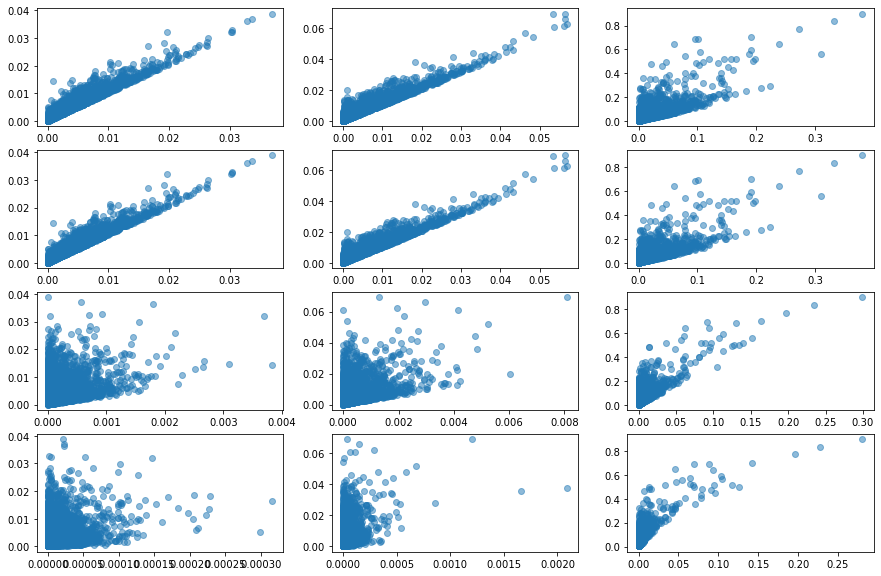

In [120]:
fig, ax = plt.subplots(4, 3, figsize=(15, 10))

for i in range(sparsity.size):
    ax[0, i].scatter(PIapprox_1[..., i].ravel(), fullPI[..., i].ravel(), alpha=0.5)
    ax[1, i].scatter(PIapprox_2[..., i].ravel(), fullPI[..., i].ravel(), alpha=0.5)
    ax[2, i].scatter(PIapprox_3[..., i].ravel(), fullPI[..., i].ravel(), alpha=0.5)
    ax[3, i].scatter(PIapprox_4[..., i].ravel(), fullPI[..., i].ravel(), alpha=0.5)

    
#     ax[0, i].set_title('First Riccati iterate, sparsity %.3f' % sparsity[sidx])
#     ax[1, i].set_title('Second Riccati iterate, sparsity %.3f' % sparsity[sidx])
# ax[0, 0].set_ylabel('True Predictive Information')
# ax[1, 0].set_xlabel('Finite Iterate Trace Approximation')
#plt.savefig('SU_Riccati_iterates.pdf', bbox_inches='tight', pad_inches=0)

In [121]:
from copy import deepcopy

In [122]:
# Co-plot the 1.5 times approximation with the 1st and second iterates
fullPI2 = deepcopy(fullPI)

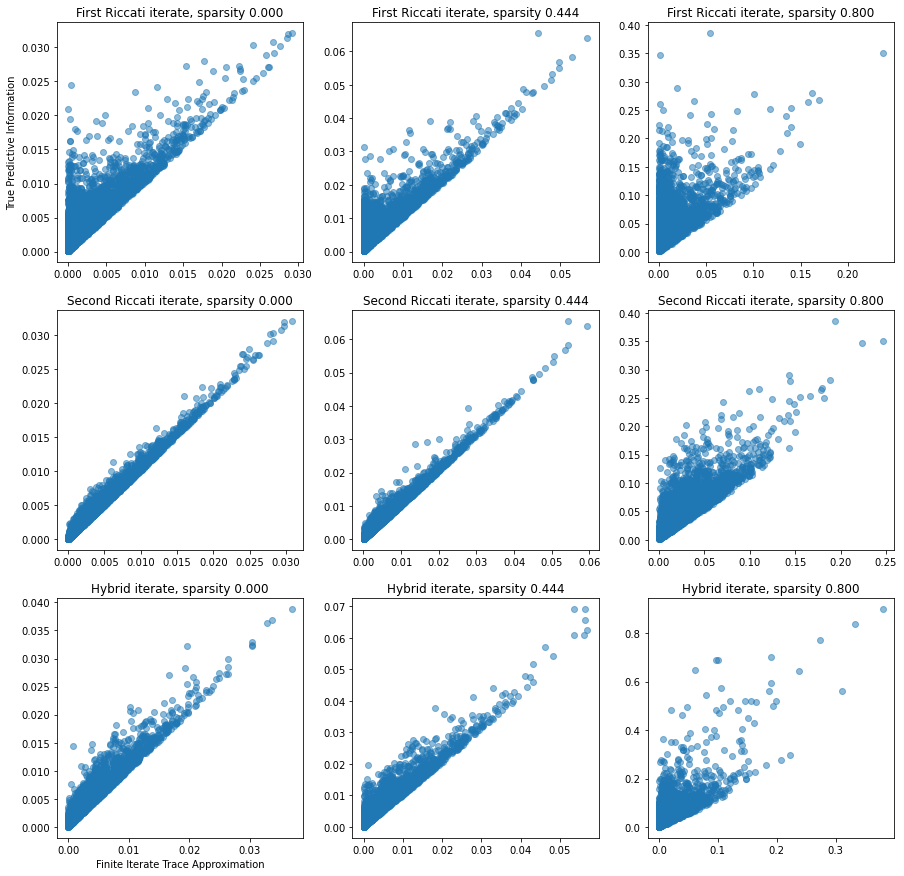

In [130]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for i, sidx in enumerate([0, 5, 9]):
    ax[0, i].scatter(singlePI[..., sidx, 0].ravel()/2, fullPI[..., sidx].ravel(), alpha=0.5)
    ax[1, i].scatter(singlePI[..., sidx, 1].ravel()/2, fullPI[..., sidx].ravel(), alpha=0.5)
    ax[2, i].scatter(PIapprox_1[..., i].ravel(), fullPI2[..., i].ravel(), alpha=0.5)
    ax[0, i].set_title('First Riccati iterate, sparsity %.3f' % sparsity[sidx])
    ax[1, i].set_title('Second Riccati iterate, sparsity %.3f' % sparsity[sidx])
    ax[2, i].set_title('Hybrid iterate, sparsity %.3f' % sparsity[sidx])
ax[0, 0].set_ylabel('True Predictive Information')
ax[2, 0].set_xlabel('Finite Iterate Trace Approximation')
plt.savefig('SU_Riccati_iterates.pdf', bbox_inches='tight', pad_inches=0)

### Do riccati iterates simply correspond to T=n DCA?

In [54]:
# It is true for T = 1)

In [14]:
ssm.C @ np.linalg.matrix_power(ssm.A, 2) @ ssm.P @ ssm.C.T

array([[0.09779049]])

In [74]:
ssm.C @ ssm.P @ np.linalg.matrix_power(ssm.A.T, 2) @ ssm.C.T

array([[0.05937666]])

In [15]:
# T = 2
ssdim = 10
A = 1/(2 * np.sqrt(ssdim)) * np.random.normal(size=(ssdim, ssdim))

if max(np.abs(np.linalg.eigvals(A))) >= 1:
    while max(np.abs(np.linalg.eigvals(A))) >= 1:
        A = 1/(2 * np.sqrt(ssdim)) * np.random.normal(size=(ssdim, ssdim)) 

B = np.eye(ssdim)
C = np.zeros((1, ssdim))
C[:, np.random.choice(np.arange(ssdim))] = 1
ssm = SSR(A = A, B = B, C = C)

In [16]:
T = np.array([[ssm.cov[0][0], ssm.autocorrelation(2)[-1, 0, 0]], 
              [ssm.autocorrelation(2)[-1, 0, 0], ssm.cov[0, 0]]])
H = np.array([[ssm.autocorrelation(3)[-1, 0, 0], ssm.autocorrelation(4)[-1, 0, 0]], 
              [ssm.autocorrelation(2)[-1, 0, 0], ssm.autocorrelation(3)[-1, 0, 0]]])

In [17]:
np.trace(np.linalg.inv(T) @ H @ np.linalg.inv(T) @ H.T)

0.014715755050984927

In [18]:
iterated_PI(ssm, 2)

(0.014715755050984929,
 array([[ 0.08598899, -0.05656109,  0.03239857, -0.04602863, -0.0002043 ,
         -0.00357337,  0.01562671, -0.00956488,  0.00465738, -0.03379515],
        [-0.05656109,  0.06241013, -0.04568635,  0.02886747,  0.01981851,
          0.02167819, -0.01669579,  0.04653873, -0.01788581,  0.05676663],
        [ 0.03239857, -0.04568635,  0.03577948, -0.01598004, -0.01911263,
         -0.02003736,  0.01209336, -0.04252515,  0.0160888 , -0.04613257],
        [-0.04602863,  0.02886747, -0.01598004,  0.02471718, -0.00099085,
          0.00083248, -0.00800608,  0.00287039, -0.00166456,  0.01615965],
        [-0.0002043 ,  0.01981851, -0.01911263, -0.00099085,  0.01537249,
          0.01510217, -0.00504837,  0.03145315, -0.01158631,  0.02705153],
        [-0.00357337,  0.02167819, -0.02003736,  0.00083248,  0.01510217,
          0.01496888, -0.0055699 ,  0.03125882, -0.01155921,  0.02788729],
        [ 0.01562671, -0.01669579,  0.01209336, -0.00800608, -0.00504837,
         

In [110]:
# Yes...

In [19]:
_, _, Q1 = iterated_PI(ssm, 1)

In [20]:
_, _, Q2 = iterated_PI(ssm, 2)

In [21]:
A.T @ Q1 @ A

array([[ 0.00049272, -0.00145416, -0.0033218 ,  0.00097099, -0.00057261,
        -0.00262056, -0.0068822 ,  0.0005142 ,  0.00051957,  0.00149228],
       [-0.00145416,  0.00429168,  0.00980365, -0.00286569,  0.00168996,
         0.00773407,  0.02031148, -0.00151755, -0.00153341, -0.00440416],
       [-0.0033218 ,  0.00980365,  0.02239485, -0.00654619,  0.00386043,
         0.01766722,  0.04639828, -0.0034666 , -0.00350284, -0.0100606 ],
       [ 0.00097099, -0.00286569, -0.00654619,  0.00191351, -0.00112843,
        -0.00516427, -0.01356259,  0.00101332,  0.00102391,  0.00294079],
       [-0.00057261,  0.00168996,  0.00386043, -0.00112843,  0.00066546,
         0.00304548,  0.00799814, -0.00059757, -0.00060382, -0.00173425],
       [-0.00262056,  0.00773407,  0.01766722, -0.00516427,  0.00304548,
         0.01393761,  0.03660344, -0.00273479, -0.00276337, -0.00793677],
       [-0.0068822 ,  0.02031148,  0.04639828, -0.01356259,  0.00799814,
         0.03660344,  0.09612925, -0.0071822 

In [ ]:
# Pseudoinverse term 

In [24]:
ssm.cov - ssm.Cbar @ Q1 @ ssm.Cbar.T

array([[1.18303543]])

In [22]:
Q2

array([[ 4.97880472e-04, -1.46939679e-03, -3.35659846e-03,
         9.81160720e-04, -5.78611081e-04, -5.59307621e-04,
        -6.95429490e-03,  5.19583135e-04,  5.25014142e-04,
         1.50790869e-03],
       [-1.46939679e-03,  4.33663708e-03,  9.90634353e-03,
        -2.89570387e-03,  1.70765738e-03,  1.65068700e-03,
         2.05242406e-02, -1.53344795e-03, -1.54947651e-03,
        -4.45029743e-03],
       [-3.35659846e-03,  9.90634353e-03,  2.26294339e-02,
        -6.61476549e-03,  3.90086612e-03,  3.77072652e-03,
         4.68842963e-02, -3.50291295e-03, -3.53952758e-03,
        -1.01659821e-02],
       [ 9.81160720e-04, -2.89570387e-03, -6.61476549e-03,
         1.93354914e-03, -1.14025453e-03, -1.10221368e-03,
        -1.37046568e-02,  1.02392962e-03,  1.03463237e-03,
         2.97159832e-03],
       [-5.78611081e-04,  1.70765738e-03,  3.90086612e-03,
        -1.14025453e-03,  6.72432044e-04,  6.49998555e-04,
         8.08192392e-03, -6.03832800e-04, -6.10144438e-04,
        -1.

In [ ]:
A.T @ n

In [121]:
1/ssm.P[26, 26]

0.8294276468138874

In [120]:
Q[26, 26]

0.8294276468138874

In [116]:
ssm.P[26, 26]**-1 * ssm.A.T @ ssm.C.T @ ssm.C @ ssm.A

array([[ 8.41612139e-03, -5.66108372e-03,  4.04237451e-04, ...,
         5.44262111e-04,  1.07974176e-03,  2.82643653e-04],
       [-5.66108372e-03,  3.80791429e-03, -2.71909345e-04, ...,
        -3.66096594e-04, -7.26285686e-04, -1.90119570e-04],
       [ 4.04237451e-04, -2.71909345e-04,  1.94160598e-05, ...,
         2.61416296e-05,  5.18614259e-05,  1.35757488e-05],
       ...,
       [ 5.44262111e-04, -3.66096594e-04,  2.61416296e-05, ...,
         3.51968837e-05,  6.98258143e-05,  1.82782809e-05],
       [ 1.07974176e-03, -7.26285686e-04,  5.18614259e-05, ...,
         6.98258143e-05,  1.38524887e-04,  3.62616152e-05],
       [ 2.82643653e-04, -1.90119570e-04,  1.35757488e-05, ...,
         1.82782809e-05,  3.62616152e-05,  9.49219133e-06]])

### Given a random projection, where do the zeros of the minimum phase system lie? Given an "optimal" projection, do the zeros discernibly lie somewhere else?

In [163]:
ssdim = 50
A = 1/(2 * np.sqrt(ssdim)) * np.random.normal(size=(ssdim, ssdim))

if max(np.abs(np.linalg.eigvals(A))) >= 1:
    while max(np.abs(np.linalg.eigvals(A))) >= 1:
        A = 1/(2 * np.sqrt(ssdim)) * np.random.normal(size=(ssdim, ssdim)) 

    
# Use the 1-Silverman step realization
B = np.eye(ssdim)
C = scipy.stats.ortho_group.rvs(ssdim)[:, 0][np.newaxis, :]
C = C @ B
B = A @ B
ssm = SSR(A = A, B = B, C = C)

In [164]:
P, _ = riccati_solve(A, ssm.C, ssm.Cbar, ssm.cov)

In [165]:
Dminus = scipy.linalg.sqrtm(ssm.cov - C @ P @ C.T)
Bminus = (ssm.Cbar.T - A @ P @ C.T) @ np.linalg.inv(Dminus)

In [166]:
ssm_min = SSR(A, Bminus, C, Dminus)

In [167]:
# Requires system to be square
def find_system_zeros(ssm):
    
    AA = np.block([[ssm.A, ssm.B], [-ssm.C, -ssm.D]])
    BB = np.block([[np.eye(ssm.A.shape[0]), np.zeros(ssm.B.shape)], 
                   [np.zeros(ssm.C.shape), np.zeros(ssm.D.shape)]])
    
    return scipy.linalg.eig(AA, BB)

In [168]:
z, zdir = find_system_zeros(ssm_min)

In [169]:
z

array([ 4.77005610e-01+0.j        ,  1.18974333e-01+0.46926917j,
        1.18974333e-01-0.46926917j,  2.96372233e-01+0.3365914j ,
        2.96372233e-01-0.3365914j ,  3.67940740e-01+0.20192003j,
        3.67940740e-01-0.20192003j, -3.28461865e-01+0.3181301j ,
       -3.28461865e-01-0.3181301j , -4.20146508e-01+0.16150383j,
       -4.20146508e-01-0.16150383j,  3.19917230e-01+0.14117386j,
        3.19917230e-01-0.14117386j,  3.26502004e-01+0.0319728j ,
        3.26502004e-01-0.0319728j , -2.33636051e-01+0.33535518j,
       -2.33636051e-01-0.33535518j, -4.99730298e-02+0.38350737j,
       -4.99730298e-02-0.38350737j, -4.25507444e-01+0.j        ,
       -1.77715108e-01+0.32866751j, -1.77715108e-01-0.32866751j,
        2.04851504e-01+0.2285889j ,  2.04851504e-01-0.2285889j ,
        2.22042333e-01+0.12385195j,  2.22042333e-01-0.12385195j,
        8.77337044e-02+0.25473573j,  8.77337044e-02-0.25473573j,
        1.52473937e-02+0.28895501j,  1.52473937e-02-0.28895501j,
       -4.45191085e-02+0.

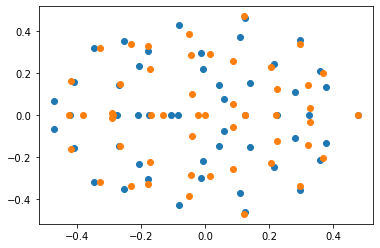

In [170]:
plt.scatter(np.real(np.linalg.eigvals(A)), np.imag(np.linalg.eigvals(A)))
plt.scatter(np.real(z), np.imag(z))

In [171]:
# OK... what about an optimal projection?

In [172]:
from dca.dca import DynamicalComponentsAnalysis as DCA

In [177]:
dcamodel = DCA(T=5, d=1)
x = SSR(A = A, B = np.eye(A.shape[0]), C=np.eye(A.shape[0])).trajectory(int(1e5))
dcamodel.fit(x)
V = dcamodel.coef_

In [178]:
B = np.eye(ssdim)
C = scipy.stats.ortho_group.rvs(ssdim)[:, 0][np.newaxis, :]
C = C @ B
B = A @ B
ssm = SSR(A = A, B = np.eye(A.shape[0]), C=V.T)

In [179]:
P, _ = riccati_solve(A, ssm.C, ssm.Cbar, ssm.cov)
Dminus = scipy.linalg.sqrtm(ssm.cov - C @ P @ C.T)
Bminus = (ssm.Cbar.T - A @ P @ C.T) @ np.linalg.inv(Dminus)
ssm_min = SSR(A, Bminus, C, Dminus)

In [180]:
z, zdir = find_system_zeros(ssm_min)

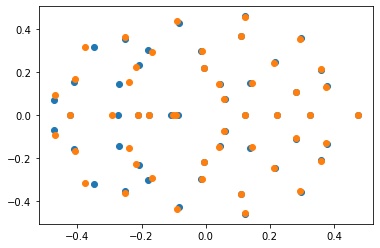

In [181]:
plt.scatter(np.real(np.linalg.eigvals(A)), np.imag(np.linalg.eigvals(A)))
plt.scatter(np.real(z), np.imag(z))

In [182]:
# There is some balancing going on between the forward an dreverse time problems...
# Can we set up an optimizer for Kalman filtering error only? This would be useful to apply to neural data as well